In [125]:
# Find out the Concrete Compressive Strength

In [126]:
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pylab as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from utils import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler,StandardScaler,MaxAbsScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
import matplotlib.pylab as plt
from imblearn.over_sampling import SMOTE
import sys

In [127]:
data_dir = os.path.abspath("./")
data_file = os.path.abspath(data_dir + "/concrete.csv")
input_data = pd.read_csv(data_file)
display(input_data.head(5))

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [128]:
display(input_data.tail(5))

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,270,55.06
1029,540.0,0.0,0.0,173.0,0.0,1125.0,613.0,7,52.61


In [129]:
input_data.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [130]:
#A scatterplot helps us to understand discrete distributions 
#of each feature and provides us with the correlation coefficent (Pearson).

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


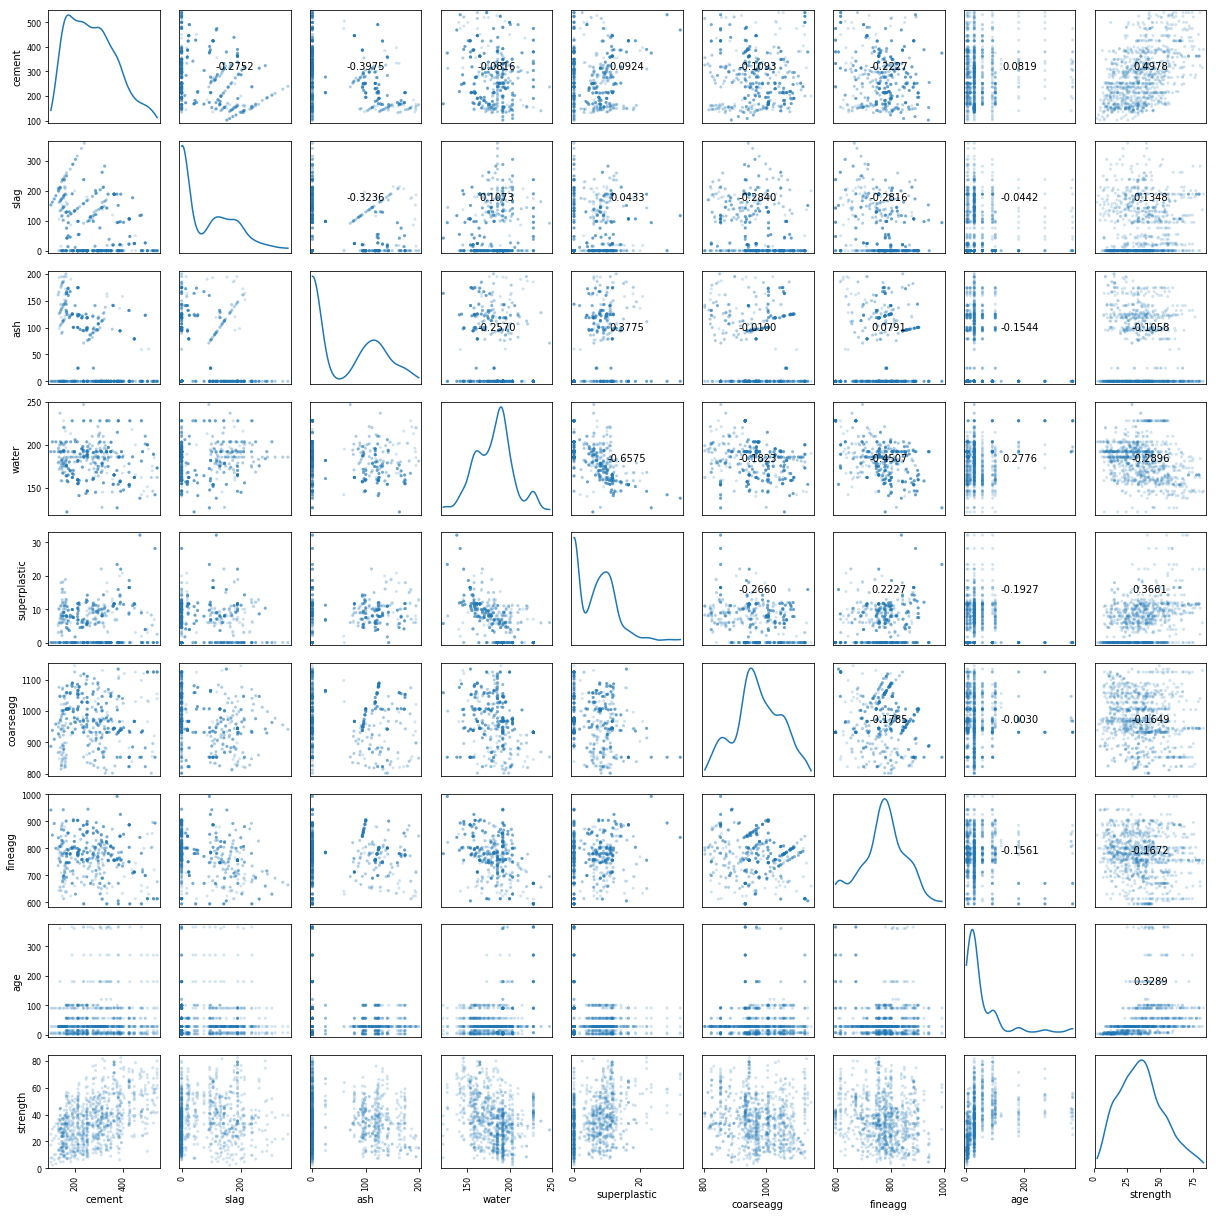

In [131]:
scatterplot_matrix  = pd.plotting.scatter_matrix(input_data, alpha=0.2, figsize=(17, 17), diagonal='kde')
corr = input_data.corr().as_matrix()
for i,j in zip (*plt.np.triu_indices_from(scatterplot_matrix, k=1)):
    scatterplot_matrix[i,j].annotate('%.4f' %corr[i,j], (0.5,0.5), xycoords='axes fraction', ha='center', va='center')
plt.tight_layout()
plt.show()

In [132]:
#The scatterplot matrix shows us that there are some features such as ‘Age’ are less evenly 
#distributed than other features. 

In [133]:
#Feature Engineering

#Water to cement
#Water to binder
#Superplasticizer to binder
#Fly ash to binder
#Slag to binder
#Fly ash + slag to binder

In [134]:
# pure water-cement ratio feature
input_features_unscaled_with_wcratio = input_data.copy()
input_features_unscaled_with_wcratio.insert(input_features_unscaled_with_wcratio.shape[-1]-1,'water-cement-ratio', input_features_unscaled_with_wcratio['water']/input_features_unscaled_with_wcratio['cement'])
input_features_unscaled_with_wcratio.drop(['water', 'cement'], axis=1, inplace=True)


In [135]:
# scale it!
scaler = MaxAbsScaler()
input_features_unscaled_with_wcratio_scaled = input_features_unscaled_with_wcratio.copy()
input_features_unscaled_with_wcratio_sc = scaler.fit_transform(input_features_unscaled_with_wcratio)
input_features_unscaled_with_wcratio_scaled.loc[:,:] = input_features_unscaled_with_wcratio_sc



In [136]:
# making the scaling function more accessible
extract_scaling_function = np.ones((1,input_features_unscaled_with_wcratio.shape[1]))
extract_scaling_function = scaler.inverse_transform(extract_scaling_function)


In [137]:
# split data into X and y
y_df = input_features_unscaled_with_wcratio_scaled['strength'].copy()
X_df = input_features_unscaled_with_wcratio_scaled.copy()
X_df.drop('strength', axis=1, inplace=True)


In [148]:
# add it to the dict of datasets for fast and iterative testing
X_train, X_test, y_train, y_test = train_test_split(X_df.values, y_df.values,test_size=0.2, random_state=42, shuffle=True)
comment = 'pure water-cement-ratio; 7 inputs, 1 output'
#datasets[dataset_id] = {'X_train': X_train, 'X_test' : X_test, 'y_train': y_train, 'y_test' : y_test, 'scaler' : scaler, 'scaler_array' : extract_scaling_function, 'comment' : comment, 'dataset' : dataset_id}
#dataset_id += 1

input_features_unscaled_with_wcratio['water-cement-ratio'].head()


0    1.440198
1    0.937241
2    0.749600
3    0.857143
4    1.248708
Name: water-cement-ratio, dtype: float64

In [149]:
#Water to Binder Ratio
input_features_unscaled_with_wcratio_full = input_data.copy()
input_features_unscaled_with_wcratio_full.insert(input_features_unscaled_with_wcratio_full.shape[-1]-1,'water-cement-ratio_with_slag_ash',input_features_unscaled_with_wcratio_full['water']/(input_features_unscaled_with_wcratio_full['cement'] + input_features_unscaled_with_wcratio_full['ash'] + input_features_unscaled_with_wcratio_full['slag']))
input_features_unscaled_with_wcratio_full.drop(['water', 'cement', 'ash', 'slag'], axis=1, inplace=True)


In [150]:
scaler = MaxAbsScaler()
input_features_unscaled_with_wcratio_full_scaled = input_features_unscaled_with_wcratio_full.copy()
input_features_unscaled_with_wcratio_full_sc = scaler.fit_transform(input_features_unscaled_with_wcratio_full)
input_features_unscaled_with_wcratio_full_scaled.loc[:,:] = input_features_unscaled_with_wcratio_full_sc
extract_scaling_function = np.ones((1,input_features_unscaled_with_wcratio_full.shape[1]))
extract_scaling_function = scaler.inverse_transform(extract_scaling_function)


In [151]:
# split data into X and y
y_df = input_features_unscaled_with_wcratio_full_scaled['strength'].copy()
X_df = input_features_unscaled_with_wcratio_full_scaled.copy()
X_df.drop('strength', axis=1, inplace=True)


In [153]:
X_train, X_test, y_train, y_test = train_test_split(X_df.values, y_df.values,test_size=0.2, random_state=42, shuffle=True)
comment = 'water-cement-ratio (binder?); 5 inputs, 1 output'
#datasets[dataset_id] = {'X_train': X_train, 'X_test' : X_test, 'y_train': y_train, 'y_test' : y_test, 'scaler' : scaler, 'scaler_array' : extract_scaling_function, 'comment' : comment, 'dataset' : dataset_id}

input_features_unscaled_with_wcratio_full['water-cement-ratio_with_slag_ash'].head()


0    0.575998
1    0.471974
2    0.542089
3    0.600000
4    0.571555
Name: water-cement-ratio_with_slag_ash, dtype: float64

In [154]:
input_features_unscaled_with_wcratio['water-cement-ratio'].describe()


count    1030.000000
mean        0.748266
std         0.314005
min         0.266893
25%         0.533333
50%         0.675349
75%         0.935165
max         1.882353
Name: water-cement-ratio, dtype: float64

In [155]:
#In this case we can use GridSearchCV from scikit-learn to train and test various hyperparameters0
#for the following algorithms (4-fold cross-validation to keep validation and test set sizes similar: both 0.2 * dataset size):

#Linear Regression
#Decision Tree Regression
#SVM Regression
#Random Forest Regression
#AdaBoost Regression
#XGBoost Regression

#In this case using the mean-squared error as a scorer is appropriate. 
#However, for later interpretation we have to re-calculate our metrics on the unscaled data as well 
#since it resembles a physical value. 

In [156]:
def xgboost_regression(X_train, X_test, y_train, y_test,scorer,dataset_id):
    x_gradient_boosting_regression = xgboost.XGBRegressor(random_state=42)
    grid_parameters_x_gradient_boosting_regression = {'n_estimators' : [3,5,10,15,18,20,25,50,60,80,100,120,150,200,300],
                                                    'max_depth' : [1,2, 3,5,7,9,10,11,15],
                                                    'learning_rate' :[ 0.0001, 0.001, 0.01, 0.1, 0.15, 0.2, 0.8, 1.0],
                                                     }
    start_time = time.time()
    grid_obj = GridSearchCV(x_gradient_boosting_regression, param_grid=grid_parameters_x_gradient_boosting_regression, cv=kfold_vs_size, n_jobs=-1, scoring=scorer, verbose=0)
    grid_fit = grid_obj.fit(X_train, y_train)
    training_time = time.time() - start_time
    best_x_gradient_boosting_regression = grid_fit.best_estimator_
    prediction = best_x_gradient_boosting_regression.predict(X_test)
    r2 = r2_score(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    mae = mean_absolute_error(y_true=y_test, y_pred=prediction)
    
    # metrics for true values
    # r2 remains unchanged, mse, mea will change and cannot be scaled
    # because there is some physical meaning behind it
    prediction_true_scale = prediction * datasets[dataset_id]['scaler_array'][:,-1]
    y_test_true_scale = y_test * datasets[dataset_id]['scaler_array'][:,-1]
    mae_true_scale = mean_absolute_error(y_true=y_test_true_scale, y_pred=prediction_true_scale)
    medae_true_scale = median_absolute_error(y_true=y_test_true_scale, y_pred=prediction_true_scale)
    mse_true_scale = mean_squared_error(y_true=y_test_true_scale, y_pred=prediction_true_scale)
    
    return {'Regression type' : 'eXtreme Gradient Boosting Regression', 'model' : grid_fit, 'Predictions' : prediction, 'R2' : r2, 'MSE' : mse, 'MAE' : mae, 'MSE_true_scale' : mse_true_scale, 'RMSE_true_scale' : np.sqrt(mse_true_scale), 'MAE_true_scale' : mae_true_scale, 'MedAE_true_scale' : medae_true_scale ,'Training time' : training_time, 'dataset' : dataset_id}


In [157]:
# NN 

def build_baseline_model(input_dim):
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='sigmoid'))
    model.add(Dense(1))
    sgd = optimizers.SGD(lr=1.0, momentum=0.5)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mae'])
    return model

In [158]:
# example of how the training process looks like for all neural networks
def run_baseline_model(X_train, X_test, y_train, y_test, dataset_id, epochs=3000,validation_split=0.2, batch_size=16):
    model = build_baseline_model(datasets[dataset_id]['X_train'].shape[1])
    
    checkpoint = callbacks.ModelCheckpoint('keras_models/model_baseline_model_'+str(dataset)+'_best.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
    start_time = time.time()
    model.fit(X_train, y_train,callbacks=[checkpoint], batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    training_time = time.time() - start_time
    
    # load best model
    model.load_weights('keras_models/model_baseline_model_'+str(dataset)+'_best.hdf5') 
    prediction = model.predict(X_test)
    r2 = r2_score(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    mae = mean_absolute_error(y_true=y_test, y_pred=prediction)
    
    # metrics for true values
    # r2 remains unchanged, mse, mea will change and cannot be scaled
    # because there is some physical meaning behind it
    prediction_true_scale = prediction * datasets[dataset_id]['scaler_array'][:,-1]
    y_test_true_scale = y_test * datasets[dataset_id]['scaler_array'][:,-1]
    mae_true_scale = mean_absolute_error(y_true=y_test_true_scale, y_pred=prediction_true_scale)
    medae_true_scale = median_absolute_error(y_true=y_test_true_scale, y_pred=prediction_true_scale)
    mse_true_scale = mean_squared_error(y_true=y_test_true_scale, y_pred=prediction_true_scale)
    
    
    return {'Regression type' : 'Baseline NN', 'model' : model, 'Predictions' : prediction, 'R2' : r2, 'MSE' : mse, 'MAE' : mae, 'MSE_true_scale' : mse_true_scale, 'RMSE_true_scale' : np.sqrt(mse_true_scale), 'MAE_true_scale' : mae_true_scale, 'MedAE_true_scale' : medae_true_scale ,'Training time' : training_time, 'dataset' : dataset_id}


In [159]:
# optimizer changed

def build_baseline_model_modified_optimizer(input_dim):
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='sigmoid'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

In [160]:
# optimizer and activation function changed

def build_baseline_model_modified_optimizer_activation_function(input_dim):
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

In [161]:
#More DNN
def build_model_1(input_dim):
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='sigmoid'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

In [162]:
def build_model_2(input_dim):
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(20, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(20, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

In [163]:
def build_model_3(input_dim):
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(30, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(50, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

In [164]:
def build_model_4(input_dim):
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(20, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(40, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(30, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model